In [6]:
reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import xarray as xr
import numpy as np
import metpy.calc as mp
from map_plot_tools import *
from line_plot_tools import *
from colorbar_funcs import *

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from shapely.geometry.polygon import LinearRing

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
from matplotlib import cm
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import cmocean
import cmocean.cm as cmo
import colorcet as cc

%config InlineBackend.figure_format = 'retina'

In [2]:
## Load data
dpath = '/Users/dervlamk/OneDrive/Topo_Biases/obs_data'
dfile = 'satellite_obs.monthly_climatologies.E2.1_grid.Mar2023.nc'
obs   = xr.open_dataset(f'{dpath}/{dfile}')
lat   = obs.lat
lon   = obs.lon
prec  = obs.precip # precip
prec.attrs['source']='IMERG'
ts    = obs.TS # skin temperature

## masks
masks = xr.open_dataset(f'/Users/dervlamk/OneDrive/Topo_Biases/topo_files/Z2HX2fromZ1QX1N.BS1.nc')

## simulations
ctrl=xr.open_dataset(f'/Users/dervlamk/OneDrive/Topo_Biases/simulations/Maxtopo/maxtopo_E2pt1_PI_restart_new.atmo.output.mon.nc')
prec_ctrl=xr.open_dataset(f'/Users/dervlamk/OneDrive/Topo_Biases/simulations/Maxtopo/maxtopo_E2pt1_PI_restart_new.atmo.output.mon.nc').prec
prec_ctrl.attrs['source']='GISS_E2.1_CPLD_CONTROL'

# Functions

#### clip a colormap

In [18]:
def clip_cmap(cmap, l_bnd, u_bnd):
    # define a new colormap by clipping a standard cmap
    cmap_full = cmap
    cmap_clip = ListedColormap(cmap_full(np.linspace(l_bnd, u_bnd)))
    return(cmap_clip)

#### combine colormaps

In [3]:
def combine_cmaps(cmap_low, cmap_up, range_low=[0,1], range_up=[0,1], n_low=128, n_up=128):
    """
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib import cm
    import matplotlib.colors as mcolors
    from matplotlib.colors import ListedColormap,LinearSegmentedColormap
    """
    # sample 128 colors from each map
    # use the range values to determine the fraction of the original cmap to clip off
    lower_colors = cmap_low(np.linspace(range_low[0], range_low[1], n_low))
    upper_colors = cmap_up(np.linspace(range_up[0], range_up[1], n_up))
    # combine them and build a new colormap
    colors = np.vstack((lower_colors, upper_colors))
    new_cmap = mcolors.LinearSegmentedColormap.from_list('new_cmap', colors)
    return(new_cmap)

#### figure out what dataset has a lower minimum or higher maximum value

In [ ]:
min(prec_obs.min(), prec_ctl.min())
max(prec_obs.max(), prec_ctl.max())

#### get_season

In [4]:
def get_season(season='jas'):
    mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['ANNUAL', 'ANN', 'ann']:
        mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['DJF', 'djf']:
        mons = [0, 1, 11]
    if season in ['JJA', 'jja']:
        mons = [5, 6, 7]
    if season in ['JJAS', 'jjas']:
        mons = [5, 6, 7, 8]
    if season in ['JFM', 'jfm']:
        mons = [0, 1, 2]
    if season in ['JAS', 'jas']:
        mons = [6, 7, 8]
    return mons

#### calc_climatology

In [276]:
def calc_climatology(ds, season='ann'):
    # First calculate the monthly climatologies
    ds_monthly_climo = ds.groupby('time.month').mean(dim='time')
    # Determine indicies of months to average over
    mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season==None:
        mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['ANNUAL', 'ANN', 'annual', 'ann']:
        mons = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    if season in ['DJF', 'djf']:
        mons = [0, 1, 11]
    if season in ['JJA', 'jja']:
        mons = [5, 6, 7]
    if season in ['JJAS', 'jjas']:
        mons = [5, 6, 7, 8]
    if season in ['JFM', 'jfm']:
        mons = [0, 1, 2]
    if season in ['JAS', 'jas']:
        mons = [6, 7, 8]
    # Calculate the annual or seasonal mean
    ds_avg = ds_monthly_climo[mons].mean(dim='month')
    return(ds_avg)

#### get_xy_coords

In [5]:
def get_xy_coords(var):
    if isinstance(var, xr.DataArray):
        x = var.metpy.x
        y = var.metpy.y
        return(x,y)
    if isinstance(var, xr.Dataset):
        print('This is a dataset. Please use an xarray DataArray')

#### plot_field

In [225]:
def plot_field(var, season='ann', vmin=None, vmax=None, cmap=None, mask=None, boundaries=None):
    
    ## get var info
    get_xy_coords(var) # get lat & lon coords without having to know coordinate names
    lons = x
    lats = y
    mons = get_season(season=season) # index months to average over based on season var
    var_avg = var[mons].mean(dim='month', keep_attrs=True) # find seasonal or annual var mean
    
    ## initialize figure
    trans = ccrs.PlateCarree()
    proj = ccrs.PlateCarree()
    fig = plt.figure(figsize=(9, 6))
    ax = plt.subplot(111, projection=proj)
    
    ## map & boundary info
    # add optional masks
    if mask != None:
        if mask in ['land', 'Land']:
            ax.add_feature(cfeature.LAND, fc=(1, 1, 1), zorder=2) # masks continents
        if mask in ['ocean', 'Ocean']:
            ax.add_feature(cfeature.OCEAN, fc=(1, 1, 1), zorder=2) # masks oceans
    # map boundaries
    if boundaries != None:
        ax.set_extent(boundaries, crs=trans) # clips map extent according to designated boundaries
    else:
        ax.set_global() # make a global map
    # add coastlines
    ax.coastlines()
    # grid line specs
    gl = ax.gridlines(crs=trans, lw=.5, colors='black', alpha=1.0, linestyle='--', zorder=10, draw_labels=True)
    gl.top_labels=False
    gl.right_labels=False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
    gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
    
    ## colormamp info
    if ((cmap==None) and (var_avg.min()<0)):
        cmap = plt.colormaps['RdBu']
    elif ((cmap==None) and (var_avg.min()>=0)):
        cmap=plt.colormaps['viridis_r']
    
    ## plot contours
    if ((vmin!=None) and (vmax!=None)):
        vn=vmin
        vx=vmax
        n_lvls = 2*(vx-vn)+1
        levels = np.linspace(vn, vx, n_lvls)
        norm = mpl.colors.BoundaryNorm(levels, cmap.N)
        cf = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
        ax.pcolormesh(lons, lats, var_avg, cmap=cmap, vmin=vn, vmax=vx, transform=trans)
    else:
        if vmin==None:
            vn=var_avg.min()
        if vmax==None:
            vx=var_avg.max()
        cf = ax.pcolormesh(lons, lats, var_avg, cmap=cmap, vmin=vn, vmax=vx, transform=trans)

    ## colorbar info
    cbar = fig.colorbar(cf,
                        extend='both',
                        orientation='vertical',
                        shrink=0.525,
                        location='right',
                        pad=0.025,
                        ax=ax)
    if 'units' in var.attrs:
        clb = var.attrs['units']
        cbar.set_label(clb, labelpad=-15, y=1.125, rotation=0)
    cbar.ax.tick_params(labelsize=10)
    for tick in cbar.ax.yaxis.get_major_ticks():
        tick.label2.set_fontweight('bold')
    
    ###
    plt.show()

#### plot_field_diff

In [ ]:
def plot_field_diff(var1, var2, season='ann',
                    vmin_fld=None, vmax_fld=None, cmap_fld=None,
                    vmin_diff=None, vmax_diff=None, cmap_diff=None,
                    mask=None, boundaries=None, cl=None,
                    var1_name='', var2_name='',
                    save=False, ofile=None):
    
    ## initialize figure
    trans = ccrs.PlateCarree()
    if cl != None:
        proj = ccrs.PlateCarree(central_longitude=cl)
    else:
        proj = ccrs.PlateCarree()
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24,6), subplot_kw={'projection': proj})
    
    ## get var info
    lons, lats = get_xy_coords(var1) # get lat & lon coords without having to know coordinate names
    mons = get_season(season=season) # index months to average over based on season var
    # find seasonal or annual var mean
    var_avg1 = var1[mons].mean(dim='month', keep_attrs=True) 
    var_avg2 = var2[mons].mean(dim='month', keep_attrs=True) 
    
    ## colormamp info
    if ((cmap_fld==None) and (var_avg1.min()<0)):
        cmap_fld=plt.colormaps['RdBu']
    if ((cmap_fld==None) and (var_avg1.min()>=0)):
        cmap_fld=plt.colormaps['viridis_r']
    if cmap_diff==None:
        cmap_diff=plt.colormaps['RdBu']
    
    ## plot contours for fields
    if ((vmin_fld!=None) and (vmax_fld!=None)):
        vn_fld=vmin_fld
        vx_fld=vmax_fld
        n_lvls_fld = 2*(vx_fld-vn_fld)+1
        levels_fld = np.linspace(vn_fld, vx_fld, n_lvls_fld)
        norm_fld = mpl.colors.BoundaryNorm(levels_fld, cmap_fld.N)
        cf_fld = mpl.cm.ScalarMappable(norm=norm_fld, cmap=cmap_fld)
        ax[0].pcolormesh(lons, lats, var_avg1, cmap=cmap_fld, vmin=vn_fld, vmax=vx_fld, transform=trans)
        ax[0].set_title(var1_name)
        ax[1].pcolormesh(lons, lats, var_avg2, cmap=cmap_fld, vmin=vn_fld, vmax=vx_fld, transform=trans)
        ax[1].set_title(var2_name)
    else:
        if vmin_fld==None:
            vn_fld=var_avg1.min()
        if vmax_fld==None:
            vx_fld=var_avg1.max()
        cf = ax[0].pcolormesh(lons, lats, var_avg1, cmap=cmap_fld, vmin=vn_fld, vmax=vx_fld, transform=trans)
        ax[0].set_title(var1_name)
        ax[1].pcolormesh(lons, lats, var_avg2, cmap=cmap_fld, vmin=vn_fld, vmax=vx_fld, transform=trans)
        ax[1].set_title(var2_name)
        
    ## plot contours for difference
    var_diff=var_avg2-var_avg1
    if ((vmin_diff!=None) and (vmax_diff!=None)):
        vn_diff=vmin_diff
        vx_diff=vmax_diff
        n_lvls_diff = 2*(vx_diff-vn_diff)+1
        levels_diff = np.linspace(vn_diff, vx_diff, n_lvls_diff)
        norm_diff = mpl.colors.BoundaryNorm(levels_diff, cmap_diff.N)
        cf_diff = mpl.cm.ScalarMappable(norm=norm_diff, cmap=cmap_diff)
        ax[2].pcolormesh(lons, lats, var_diff, cmap=cmap_diff, vmin=vn_diff, vmax=vx_diff, transform=trans)
        ax[2].set_title(f'{var2_name}$-${var1_name}')
    else:
        if vmin_diff==None:
            vn_diff=var_diff.min()
        if vmax_diff==None:
            vx_diff=var_diff.max()
        cf = ax[2].pcolormesh(lons, lats, var_diff, cmap=cmap_diff, vmin=vn_diff, vmax=vx_diff, transform=trans)
        ax[2].set_title(f'{var2_name}$-${var1_name}')
    
    for i in [0,1,2]:
        ## map & boundary info
        # add optional masks
        if mask != None:
            if mask in ['land', 'Land']:
                ax[i].add_feature(cfeature.LAND, fc=(1, 1, 1), zorder=2) # masks continents
            if mask in ['ocean', 'Ocean']:
                ax[i].add_feature(cfeature.OCEAN, fc=(1, 1, 1), zorder=2) # masks oceans
        # map boundaries
        if boundaries != None:
            ax[i].set_extent(boundaries, crs=trans) # clips map extent according to designated boundaries
        else:
            ax[i].set_global() # make a global map
        # add coastlines
        ax[i].coastlines()
        # grid line specs
        gl = ax[i].gridlines(crs=trans,
                             lw=.5,
                             colors='black',
                             alpha=1.0,
                             linestyle='--',
                             zorder=10,
                             draw_labels=True)
        gl.top_labels=False
        gl.right_labels=False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'color': 'black', 'weight': 'bold'}
        gl.ylabel_style = {'color': 'black', 'weight': 'bold'}
    
        ## colorbar info
        if 'units' in var.attrs:
            clb = var_avg1.attrs['units']
        if i in [0,1]:
            cbar = fig.colorbar(cf_fld,
                                extend='both',
                                orientation='horizontal',
                                shrink=0.9,
                                location='bottom',
                                pad=0.075,
                                ax=ax[i])
            cbar.set_label(clb, labelpad=5, y=1, rotation=0, fontweight='bold')
            cbar.ax.tick_params(labelsize=10)
            for tick in cbar.ax.xaxis.get_major_ticks():
                tick.label1.set_fontweight('bold')
        else:
            cbar = fig.colorbar(cf_diff,
                                extend='both',
                                orientation='horizontal',
                                shrink=0.9,
                                location='bottom',
                                pad=0.075,
                                ax=ax[i])
            cbar.set_label(clb, labelpad=5, y=1, rotation=0, fontweight='bold')
            cbar.ax.tick_params(labelsize=10)
            for tick in cbar.ax.xaxis.get_major_ticks():
                tick.label1.set_fontweight('bold')

    ###
    plt.show()

#### plot_tseries

In [166]:
def plot_tseries(var):
    
    # get time variable (only works if time is first dimension)
    t_name = var.dims[0]
    time = var[t_name]
    
    # make plot
    fig = plt.figure(figsize=(9, 6))
    ax = plt.subplot(111)

    ax.plot(time, var, c='r', lw=2, linestyle='-', label=var.name) 
    
    # set axes information
    xlb = t_name
    if 'units' in var.attrs:
        ylb = var.attrs['units']
    ax.set(xlabel=xlb, ylabel=ylb)
    
    # legend
    ax.legend(loc=0, frameon=False, fontsize=10)

    ###
    plt.show()

In [179]:
dpath = '/Users/dervlamk/OneDrive/Topo_Biases/simulations/Maxtopo'
dfile = 'nt_Heat_Atl_2650-2999.maxtopo_E2pt1_PI_restart_new.nc'

nth_atl = xr.open_dataset(f'{dpath}/{dfile}').nt_Heat_Atl

/Users/dervlamk/opt/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/coding/times.py:710: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/Users/dervlamk/opt/anaconda3/envs/climate/lib/python3.11/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


# INFO

### FIGURE FORMATTING

RC params?

### COLORMAPS & COLORBAR FORMATTING

**LOADING AND MODIFYING COLORMAPS**
* [matplotlib named colors reference](https://matplotlib.org/stable/gallery/color/named_colors.html)
* [matplotlib colormaps reference](https://matplotlib.org/stable/gallery/color/colormap_reference.html)
* [cmocean colormaps reference](https://matplotlib.org/cmocean/)

```python
# load a matplotlib colormap
cmap=plt.colormaps['Blues']
# load a cmocean colormap
cmap=cmocean.cm.rain
# add _r to end of colormap name to load a colormap with the order of its colors reversed
cmap=plt.colormaps['RdYlBu_r'] # works for matplotlib cmaps
cmap=cmocean.cm.rain_r         # and for cmocean cmaps

# define a new colormap by clipping a standard cmap
# if it's a divergent colormap, should clip equally from the top and bottom
cmap_full=cmocean.cm.rain
cmap_clip=ListedColormap(cmap_full(np.linspace(0.25, 0.75)))
# define a new colormap by clipping a standard cmap (custom function)
cmap_clip=clip_cmap(cmap,    # colormap
                    pct_low, # fraction of cmap to start at
                    pct_up)  # fraction of cmap to end at

# create a new, discrete colormap from matplotlib colors (good for categorical data)
cmap=['mediumviolet','deeppink','lavenderblush','lavender','lightsteelblue','cornflowerblue']

# create a continuous colormap from matplotlib colors
cvals =[-1, -0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75, 1]                    # define boundary values
colors=['orchid', 'plum', 'mistyrose','seashell', 'white',
        'lightcyan', 'lightskyblue', 'mediumpurple', 'slateblue']         # define colors
tuples=list(zip(map(plt.Normalize(min(cvals),max(cvals)),cvals), colors)) # create list of tuples
cmap=mcolors.LinearSegmentedColormap.from_list("", tuples)                # create cmap

# create a new colormap by combining two existing colormaps (custom function)
new_cmap=combine_cmaps(cmap_low,        # lower colormap
                       cmap_up,         # upper colormap
                       range_low=[0,1], # percent of lower colormap to clip [(0-1),(0-1)]
                       range_up=[0,1],  # percent of upper colormap to clip [(0-1),(0-1)]
                       n_low=128,       # number of levels in lower colormap
                       n_up=128)        # number of levels in upper colormap
```
---

**CREATING AN OBJECT TO MAP ONTO THE COLORBAR**

**To create a continuous colormap, can create a variable of the contours and plug it in when calling the colorbar function**
```python
cf=ax.pcolormesh(x, y, var, vmin, vmax, transform=trans)
cbar=fig.colorbar(cf, ...)
```

**To create a discrete colormap, need to set the number of levels and normalization**
```python
levels=np.linspace(vmin, vmax, n_lvls)
norm=mpl.colors.BoundaryNorm(levels, cmap.N)
cf=mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
cbar=fig.colorbar(cf, ...)
```

---

**COLORBAR LOCATION**
* simple procedure for designating colorbar location (probably have to set shrink also)
```python
location='right', 'left', 'top', 'bottom'
cbar = fig.colorbar(..., location=location, ax=ax)
```
* designate a colorbar axis
```python
cbar_ax = fig.add_axes([xpos, ypos, xwidth, ywidth]) #e.g. [.9, .1, .025, .75]
cbar    = fig.colorbar(..., cax=cbar_ax)
```

---

**COLORBAR FORMATTING**
```python
## kwargs within fig.colorbar function
label = # colorbar label
extend = 'both', 'min', 'max'
orientation = 'horizontal', 'vertical'
format = '%4.2e' # adjust significant figs of labels
pad = # fraction of original axes between colorbar and fig axes (defaults: vert=0.05, horz=0.15)

## Change font size of colorbar labels
cbar.ax.tick_params(labelsize=10)

## Make colorbar labels bold (label1=horizontal cbar, label2=vertical cbar)
for tick in cbar.ax.yaxis.get_major_ticks():
    tick.label2.set_fontweight('bold')
```

### AXES FORMATTING

```python
# add x and/or y labels and limits
ax.set(xlabel=xlb, xlim=[lower_limit, upper_limit],
       ylabel=ylb, ylim=[lower_limit, upper_limit])
# can reverse the axes by putting the higher value in the first position of the limits
ax.set(xlabel=xlb, xlim=[upper_limit, lower_limit],
       ylabel=ylb, ylim=[lower_limit, upper_limit])
# specify the tick intervals
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.yticks([0, 1, 2, 3, 4, 5])
# to specify cartopy tick intervals, need to include projection
ax.set_xticks([0, 60, 120, 180, 240, 300, 360], crs=ccrs.PlateCarree())

# define tick axes kwargs
tkw = {'axis': 'both',         # x, y, both
       'width': 1,             # tick width
       'length': 4,            # tick length
       'direction':'in',       # in, out, both
       'color': 'k',           # tick color
       'labelsize': 10,        # label font size
       'labelcolor': 'k',      # label color
       'labelrotation': 0,     # angle of label
       'labelbottom': True,    # draw bottom labels
       'labelleft': True,      # draw left labels
       'labeltop': False,      # draw top labels
       'labelright': False,    # draw right labels
       'grid_color': 'k',      # grid line color
       'grid_linewidth': 0.5,  # grid line width
       'grid_linestyle': '--'  # grid line style
      }      
# apply kwargs
ax.tick_params(**tkw)
# To make tick labels bold, not sure of a better solution other than
plt.xticks(weight='bold')
plt.yticks(weight='bold')
# set number of decimal places to show
ax.xaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.2f'))
ax.yaxis.set_major_formatter(mpl.ticker.FormatStrFormatter('%0.2f'))
# change color of axes spine
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
```

### LEGEND FORMATTING

```python
# define legend kwargs
legend_kw = {'loc':1,                   # best/0, upper right/1, upper left/2, lower left/3, lower right/4
             'bbox_to_anchor':[1,1],    # specifies [x, y] position of the legend corner based on loc
             'ncols':1,                 # number of columns
             'fontsize':12,             # label size
             'labelcolor':'linecolor',  # label color determined by line color
             'markerscale':1,           # scale of markers relative to ones on the plot
             'handletextpad':0.2,       # distance between marker and label (default=0.8)
             'frameon':True,            # draw a box around the legend
             'fancybox':False,          # True: rounded edges, False: square edges
             'framealpha':0.5,          # set to a value (O-1.0) to make legend background transparent
             'facecolor':None,          # specify color or set to 'inherit' to use plot background color
             'edgecolor':'black',       # legend patch edge color
             'title':None               # add a string to set a legend title
            }

# draw legend
ax.legend(**legend_kw) # includes all objects in the legend, gets labels from object labels property
ax.legend([obj1, obj2], **legend_kw) # specify objects to include, gets labels from object labels property
ax.legend([obj1, obj2], ['label1', 'label2'], **legend_kw) # specify objects to include and their labels
```

### TEXT FORMATTING & ANNOTATIONS

**TEXT**
```python
# define text kwargs
text_kw={'family': 'serif',        # 'serif' 'sans-serif' 'cursive' 'fantasy' 'monospace'
         'size': 'medium',         # 'xx-small' 'x-small' 'small' 'medium' 'large' 'x-large' 'xx-large'
         'weight': 'black',        # 'light' 'normal' 'medium' 'semibold' 'bold' 'heavy' 'black'
         'style': 'italic',        # 'normal' 'italic' 'oblique'
         'variant': 'small-caps',  # 'normal' 'small-caps'
         'ha': 'left',             # horizontal alignment: 'center' 'right' 'left'
         'va': 'center',           # vertical alignment: 'center' 'top' 'bottom' 'baseline'
         'color': 'black',
         'backgroundcolor':'white',
         'alpha': 1.0
        }
# add text: x and y positions use axes units, input values beyond axes range will plot text outside the axes
ax.text(x, y, 'text', **text_kw)
```
***

**ARROWS**<br>

connection styles:
* **diagonal arrow with small kink:** 'arc, angleA=0, armA=40, angleB=-90, armB=30, rad=7'
* **arrow with a 90° arc:** 'angle, angleA=0, angleB=90, rad=10'
* **arrow with 1 x 90° angle:** 'angle3, angleA=0, angleB=90'
* **arrow with 2 x 90° angles:** 'bar'

```python
## define arrow properties
# line arrows
arrow_kw={'arrowstyle':'<-',   # '-' '<-' '->' '<->' '<|-' '-|>' '<|-|>' ']-' '-[' ']-[' '|-|'
          'color':'k',         # line color
          'linewidth':2,       # line width
          'shrinkA':0.05,      # move arrow tip some fraction away from point A
          'shrinkB':0.05,      # move arrow base some fraction away from point B
          'connectionstyle':'' # leave out for a straight arrow, otherwise set
        }
# shape arrows:
arrow_kw={'arrowstyle':'wedge', # 'simple' 'fancy' 'wedge'
          'fc':'w',             # face color, if using simple, fancy, or wedge
          'ec': 'k',            # edge color, if using simple, fancy, or wedge
          'shrinkA':0.05,       # move arrow tip some fraction away from point A
          'shrinkB':0.05,       # move arrow base some fraction away from point B
          'connectionstyle':''  # leave out for a straight arrow, otherwise set 
        }
# text box properties
bbox={'boxstyle':'square',   # 'square', 'circle', 'ellipse', 'round', 'round4', 'sawtooth', 'roundtooth'
      'fc':'blue',           # face color
      'ec':'black',          # edge color
      'alpha':0.5,           # transparency
      'pad':.5               # add space between text and box edge
     }

# add annotation
ax.annotate('label', xy=(x1,y1), xytext=(x2,y2), label='_Hidden', arrowprops=arrow_kw, **text_kw)
# add annotation with box around text
ax.annotate('label', xy=(x1,y1), xytext=(x2,y2), label='_Hidden', bbox=bbox, arrowprops=arrow_kw, **text_kw)
```

### PATCHES

```python
# define kwargs
patch_kw = {'edgecolor':'k',     # edge line color
            'linewidth':1,       # edge line width
            'linestyle':'-',     # edge line style
            'facecolor':'blue',  # patch face color
            'alpha':0.25,        # patch transparency
            'hatch':'///',       # draw hatching: '/', '\', '|', '-', '+', 'x', 'o', 'O', '.', '*'
            'fill':True          # if false, only border and hatching is drawn
             }

# rectangle: (x,y) are coordinates of the lower left corner, width & height are relative to axes units
pp=plt.Rectangle((x, y), width, height, label='_Hidden', zorder=1, **patch_kw) 
ax.add_patch(pp) 

# circle: (x,y) are coordinates of circle center, diameter is relative to axes units
# will plot as an ellipse if the axes aren't on the same scale
pp=plt.Circle((x, y), diameter, label='_Hidden', zorder=1, **patch_kw) 
ax.add_patch(pp) 

# polygon
pp=plt.Polygon([[x1, y1], [x2, y2], [x3, y3]], label='_Hidden', zorder=1, **patch_kw) 
ax.add_patch(pp) 
```

### SPECIAL LINES & LINE PLOT FORMATTING

**LINE FORMATTING**
```python
line_kw={'ls': '-',             # line style: '-', '--', '-.', ':', ''
         'lw': 1,               # line width
         'c': 'k',              # line color
         'marker': 'o',         # add markers to line: 'o' 'd' 's' '>' '<' '^' '+'
         'ms': 100,             # marker size
         'mec': 'k',            # marker edge color
         'mew': 0.5,            # marker edge width
         'mfc': 'r',            # marker face color
         'alpha': 1.0,          # transparency
         'drawstyle': 'default' # for stepped line, choose: 'steps', 'steps-pre', 'steps-mid', 'steps-post'
        }
```
---

**SPECIAL LINES**
```python
# add a horizontal line at a specific y value
ax.axhline(y=10, color='gray', linewidth=2, linestyle='--', label='_Hidden') 

# add a vertical line at a specific x value
ax.axvline(x=10, color='black', linewidth=.75, linestyle='-', label='_Hidden') 

# add 1:1 line, (xval, yval) are the coordinates where you want the line to start
ax.axline((xval, yval), slope=1, color='k', lw=2, linestyle='-', label='1:1 Line')
```

### MARKERS & SCATTER PLOT FORMATTING

### ERROR BARS & UNCERTAINTY BOUNDS

**FILLED ERROR PATCH**
```python
# define upper and lower y bounds
y_lower=#values
y_upper=#values
ax.fill_between(x,y_lower,y_upper,facecolor=(0,0,0,0.3),lw=0,zorder=1)

```

***

**ERROR BARS**
```python
# add a horizontal line at a specific y value

```

In [ ]:
errs = [
    (axs[0], "constant error", 0.05),
    (axs[1], "variable error", 0.05 * np.sin(2 * t) ** 2 + 0.04),
]
for i, (ax, title, err) in enumerate(errs):
    ax.set(title=title, aspect=1, xticks=[], yticks=[])
    ax.plot(x, y, "k")
    draw_error_band(ax, x, y, err=err,
                    facecolor=f"C{i}", edgecolor="none", alpha=.3)

### MAPS

ADD HATCHES TO MAP (I.E. TO REPRESENT SIGNIFICANCE)

POSSIBLE HATCH STYLES, repeat symbol to increase density or combine styles to create a new style
hatches = ['/', '\\', '|', '-', '+', 'x', 'o', 'O', '.', '*']

for significance, need to have at least two levels, can use empty brackets for levels you don't want hatched
hatches=['','///']

# PLOT DEMOS

### SIMPLE LINE PLOT

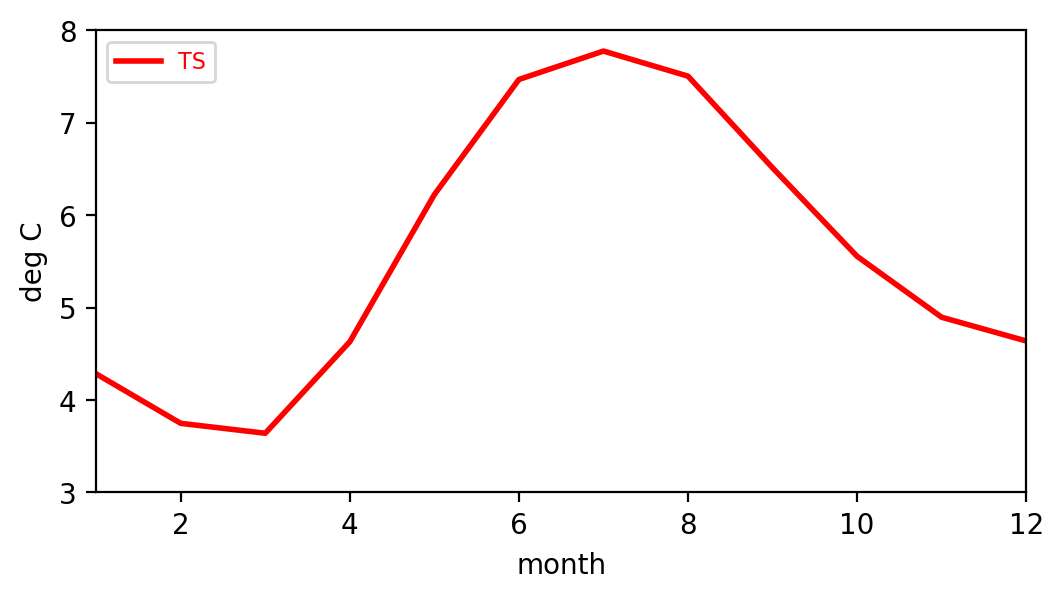

In [540]:
# calculate global mean surface temperature (unweighted)
var = ts.mean(dim=['lat','lon'], keep_attrs=True)-273.15 
# make time variable
month = var['month'] 

# legend kwargs
legend_kw = {'loc':2,
             'fontsize':8,
             'labelcolor':'linecolor',
             'frameon':True} 
# line kwargs
line_kw={'ls':'-',
         'lw':2,
         'c':'r'} 

# initialize figure
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(111)

# plot var data
ax.plot(time, var, label=var.name, **line_kw) 

# set axes information
ax.set(xlabel=month.name, xlim=[1,12],
       ylabel='deg C', ylim=[3, 8])
    
# draw legend
ax.legend(**legend_kw)

### SUBPLOTS THAT SHARE AN X-AXIS

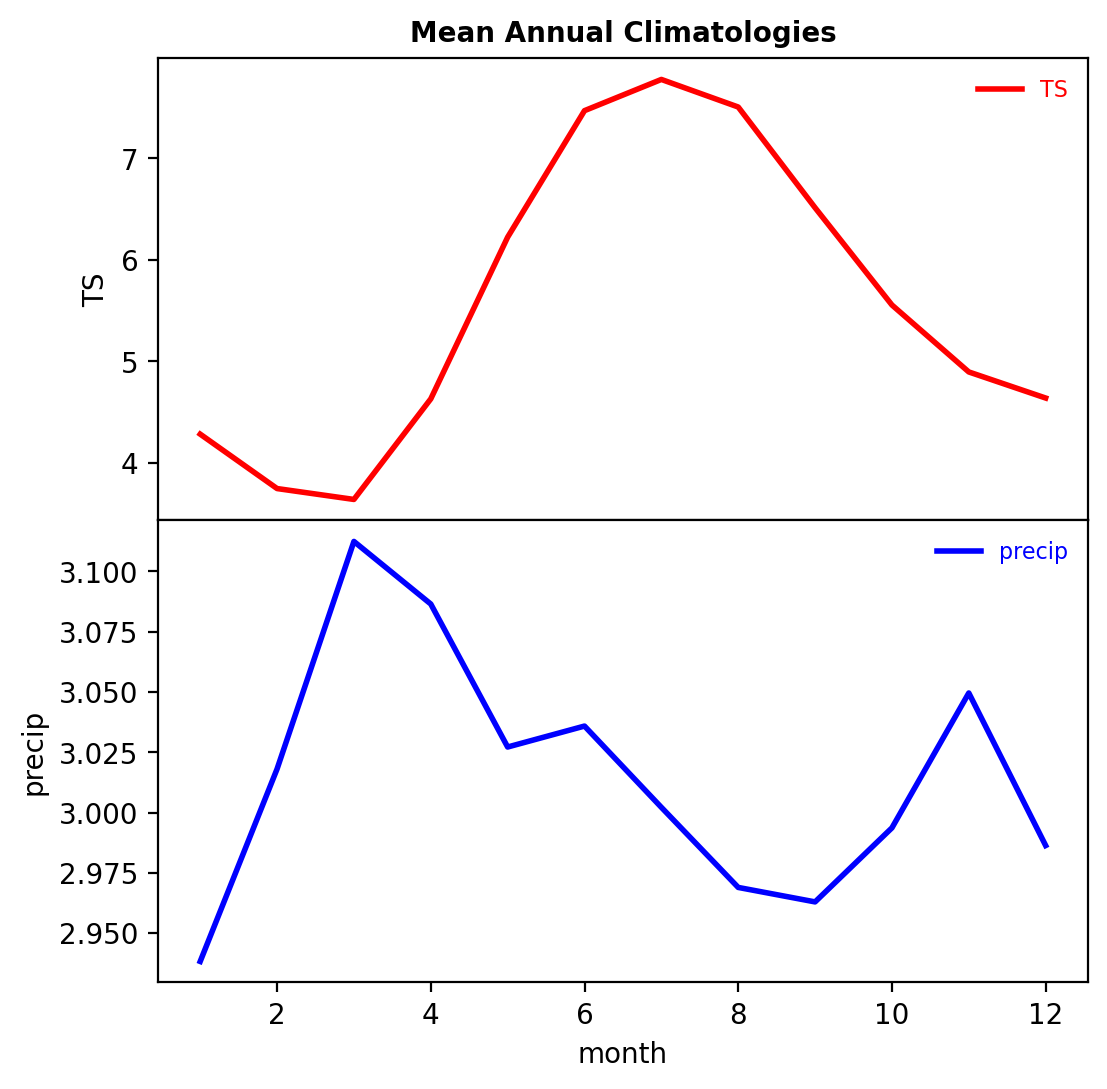

In [541]:
# calculate global means
var1 = ts.mean(dim=['lat','lon'], keep_attrs=True)-273.15
var2 = prec.mean(dim=['lat','lon'], keep_attrs=True)
# make time variable
month = var1['month']
    
legend_kw = {'loc':1, 
             'fontsize':8,
             'labelcolor':'linecolor',
             'frameon':False}
text_kw={'size': 'medium',
         'weight': 'bold', 
         'color': 'k'}

# initialize figure
fig = plt.figure(figsize=(6, 6))
# add subplots with no vertical space between then
gs = fig.add_gridspec(2, hspace=0)
# specify that the subplots share the x axes
ax = gs.subplots(sharex=True, sharey=False)

# plot timeseries
ax[0].set_title(('Mean Annual Climatologies'), **text_kw)
ax[0].plot(month, var1, c='r', lw=2, linestyle='-', label=var1.name) 
ax[0].set(ylabel=var1.name)
ax[0].legend(**legend_kw)

ax[1].plot(month, var2, c='b', lw=2, linestyle='-', label=var2.name) 
ax[1].set(xlabel=month.name, ylabel=var2.name)
ax[1].legend(**legend_kw)

# Hide x labels and tick labels for all but bottom plot
for ax in ax:
    ax.label_outer()

### LINE PLOT WITH DIFFERENT LEFT/RIGHT Y-AXES

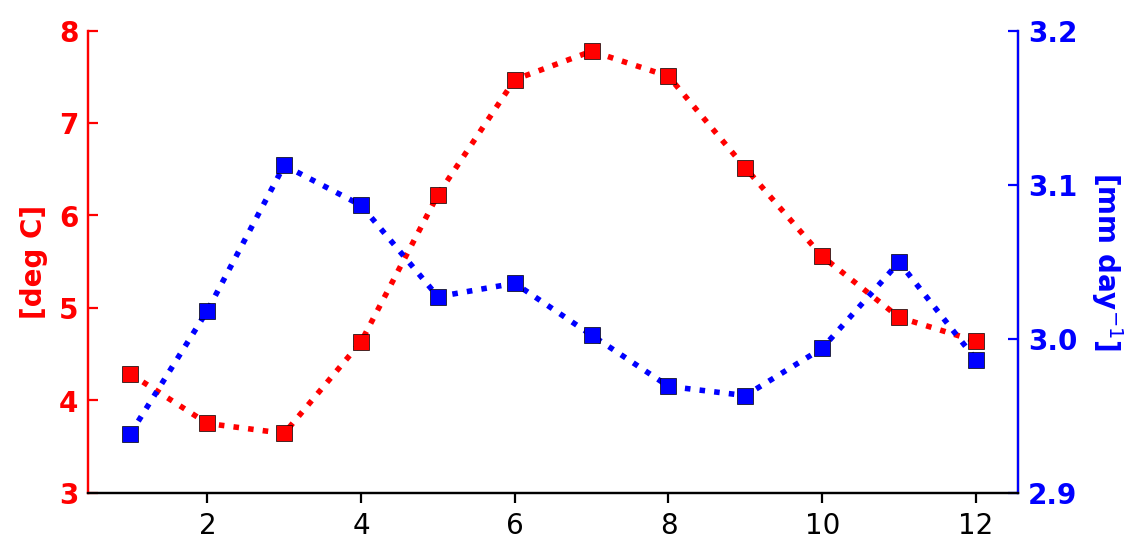

In [593]:
### +++ Line Plot With 2 Y-Axes +++ ### 

# calculate global means
var1 = ts.mean(dim=['lat','lon'], keep_attrs=True)-273.15
var2 = prec.mean(dim=['lat','lon'], keep_attrs=True)
# make time variable
month = var1['month']
    
legend_kw = {'loc':1, 
             'fontsize':8,
             'labelcolor':'linecolor',
             'frameon':False}
text_kw={'size': 'medium',
         'weight': 'bold', 
         'color': 'k'}
line_kw={'ls':':',
         'lw':2,
         'marker':'s',
         'mec':'k',
         'mew':0.25} 
tkw = {'axis': 'y',
       'direction':'in',
       'labelsize': 10,} 

# initialize figure
fig = plt.figure(figsize=(6, 3))

# create subplot
ax1 = plt.subplot(111)
# plot temp data
ax1.plot(month, var1, c='r', mfc='r', label=var1.name, **line_kw) 
ax1.set(ylim=[3, 8])
ax1.set_ylabel('[deg C]', color='r', weight='bold')
ax1.tick_params(color='r', labelcolor='r', **tkw)
ax1.spines['left'].set_color('red')
plt.yticks(np.arange(3,9,1), weight='bold')

# instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx() 
# plot precip data
ax2.plot(month, var2, c='b', mfc='b', label=var2.name, **line_kw) 
ax2.set(ylim=[2.9, 3.2])
ax2.set_ylabel('[mm day$^{-1}$]', color='b', weight='bold', rotation=270, labelpad=17)
ax2.tick_params(color='b', labelcolor='b', **tkw)
plt.yticks([2.9, 3.0, 3.1, 3.2], weight='bold')

ax1.spines['top'].set_color('none')
ax2.spines['top'].set_color('none')
ax2.spines['left'].set_color('red')
ax2.spines['right'].set_color('blue')

### LINE PLOT WITH A PATCH AND HORIZONTAL LINE

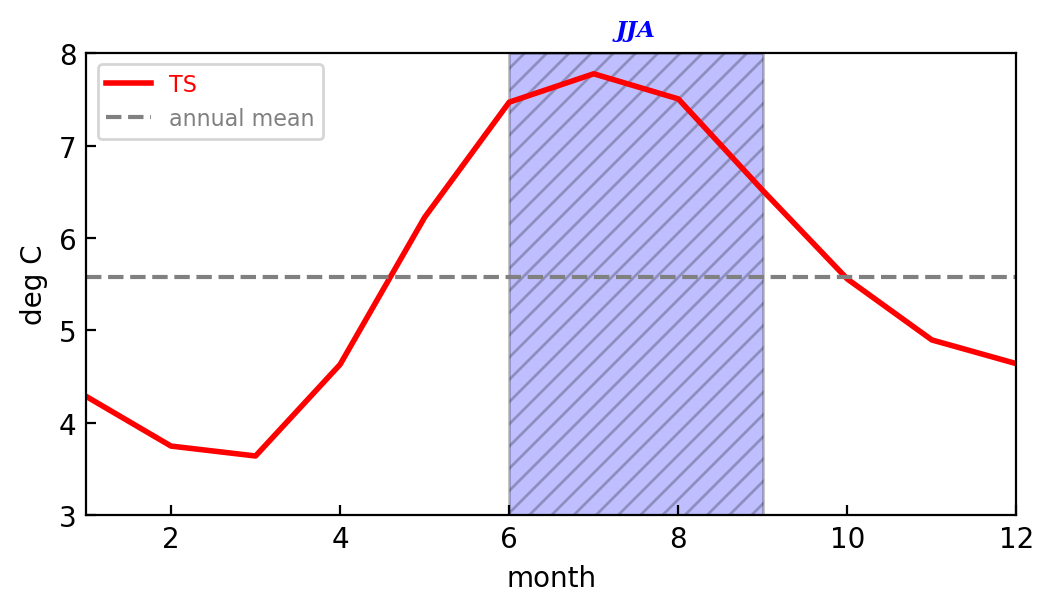

In [596]:
### +++ Line Plot with Patch and H Line +++ ### 

tkw = {'axis': 'both',
       'direction':'in',
       'color': 'k',
       'labelsize': 10,
       'labelcolor': 'k'}      

patch_kw = {'edgecolor':'k',
            'linewidth':1,
            'linestyle':'-',
            'facecolor':'blue',
            'alpha':0.25,
            'hatch':'///'}

text_kw={'family': 'serif',
         'size': 'small',
         'weight': 'black', 
         'style': 'italic',
         'ha': 'center',
         'va': 'center',
         'color': 'blue'}

legend_kw = {'loc':2, 
             'fontsize':8,
             'labelcolor':'linecolor',
             'frameon':True}

# calculate global mean
var = ts.mean(dim=['lat','lon'], keep_attrs=True)-273.15

# make time variable
month = var['month']
    
# make figure
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(111)

# plot timeseries
ax.plot(time, var, c='r', lw=2, linestyle='-', label=var.name) 
# plot annual mean
ax.axhline(y=var.mean(), color='gray', linewidth=1.5, linestyle='--', label='annual mean') 
# plot patch around JJA
pp=plt.Rectangle((6, 0), 3, 8, zorder=1, label='_Hidden', **patch_kw) 
ax.add_patch(pp) 
ax.text(7.5, 8.25, 'JJA', **text_kw)

# set axes information
xlb = month.name
ylb = 'deg C'
ax.set(xlabel=xlb, xlim=[1,12],
       ylabel=ylb, ylim=[3, 8])
ax.tick_params(**tkw)

# draw legend
ax.legend(**legend_kw)

### TIMESERIES WITH 1-SIGMA UNCERTAINTY SHADING

In [ ]:
var = ts.mean(dim=['lat','lon'])
error = ts.std(dim=['lat','lon']) #np.random.normal(0.25, 0.05, size=var.shape)

legend_kw = {'loc':2, 
             'fontsize':8,
             'labelcolor':'k',
             'frameon':True}

# make figure
fig, ax = plt.subplots(figsize=(6, 3))

# plot data
ax.plot(month, ts_mean, '-bo', markersize=3, zorder=2, label='mean')
ax.fill_between(month, var-error, var+error, facecolor='b', alpha=0.25, zorder=1, label='1-sigma uncertainty')

ax.set(xlabel='month', ylabel='[K]')
plt.xticks(np.arange(1,13,1))
# draw legend
ax.legend(**legend_kw)

### SIMPLE SCATTER PLOT

[Text(0.5, 0, 'Obs'), Text(0, 0.5, 'Model')]

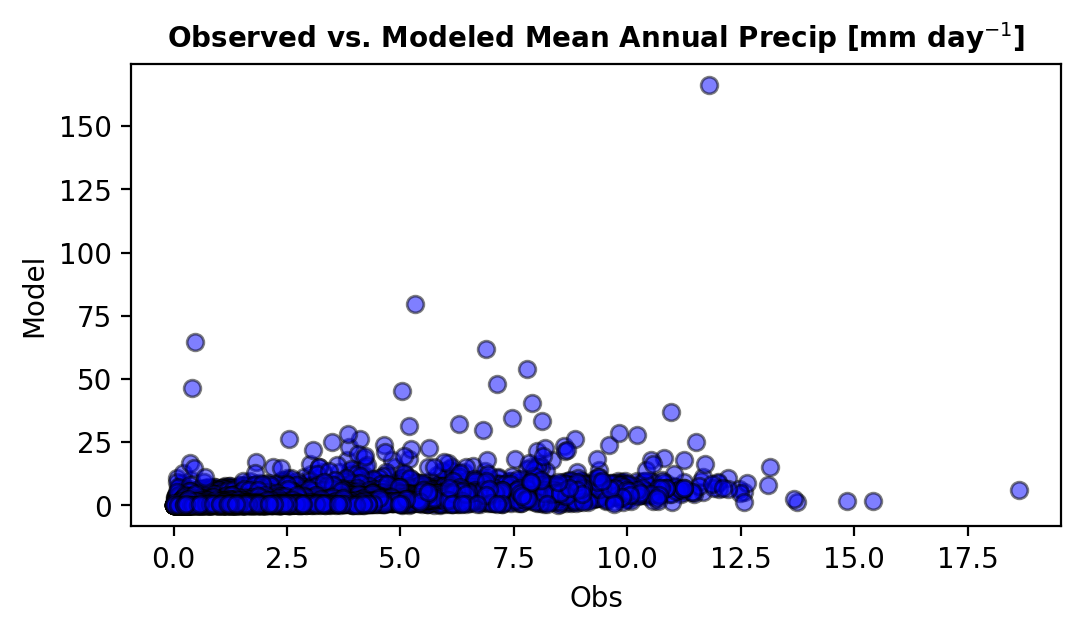

In [605]:
### +++ Simple Scatter Plot +++ ### 

# calculate time means
pObs = prec.mean(dim=['month'], keep_attrs=True)
pCtl = prec_ctrl.mean(dim=['month'], keep_attrs=True)

text_kw={'size': 'medium',
         'weight': 'bold', 
         'color': 'black'}

# make figure
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(111)

# set title
ax.set_title('Observed vs. Modeled Mean Annual Precip [mm day$^{-1}$]', **text_kw)

# plot precip vs. precip
ax.scatter(pObs, pCtl, c='b', edgecolors='k', alpha=.5, label='precip') 
ax.set(xlabel='Obs', ylabel='Model')


### SCATTER PLOT WITH 1:1 LINE, PATCH, AND ANNOTATION

[Text(0.5, 0, 'IMERG'),
 (0.0, 16.0),
 Text(0, 0.5, 'GISS_E2.1_CPLD_CONTROL'),
 (0.0, 50.0)]

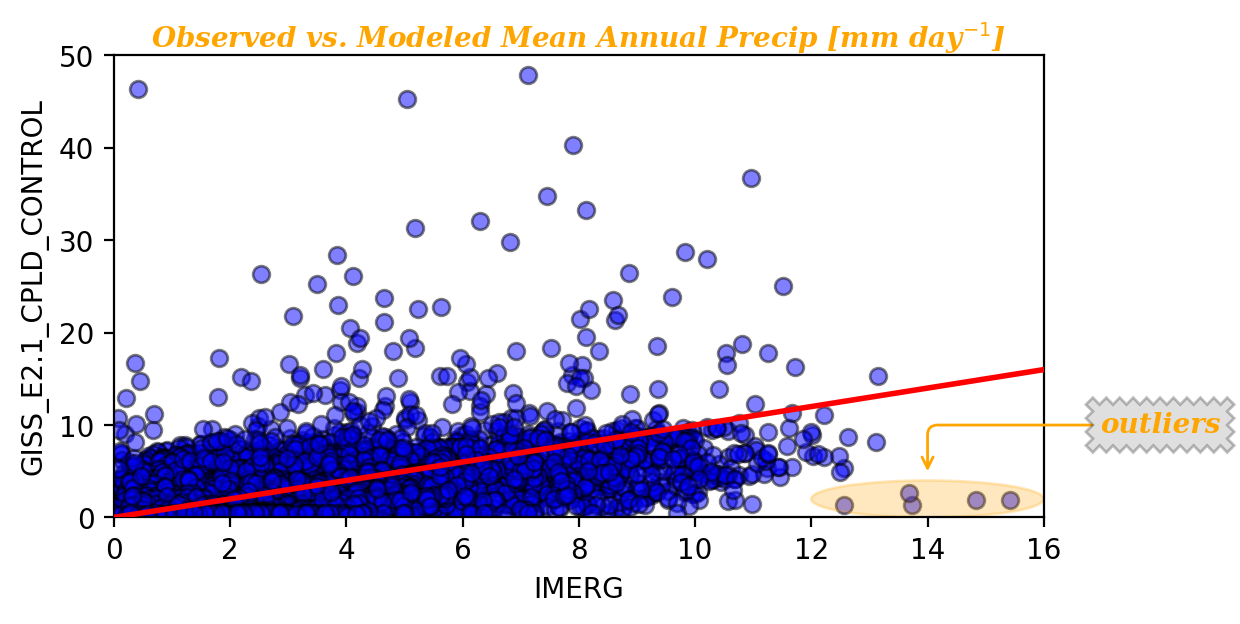

In [609]:
patch_kw = {'edgecolor':'orange',
            'linewidth':1,
            'linestyle':'-',
            'facecolor':'orange',
            'alpha':0.25}

text_kw={'family': 'serif',
         'size': 'medium',
         'weight': 'black', 
         'style': 'italic',
         'ha': 'center',
         'va': 'center',
         'color': 'orange'}

arrow_kw={'arrowstyle':'->', 
          'color':'orange',
          'linewidth':1,
          'shrinkA':0,
          'shrinkB':0,
          'connectionstyle':'angle,angleA=0,angleB=90,rad=10'
        }

bbox={'boxstyle':'sawtooth',
      'fc':'grey',
      'ec':'black',
      'alpha':0.25,
      'pad':.5
     }

# calculate time means
pObs = prec.mean(dim=['month'], keep_attrs=True)
pCtl = prec_ctrl.mean(dim=['month'], keep_attrs=True)

# make figure
fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(111)
# set title
ax.set_title('Observed vs. Modeled Mean Annual Precip [mm day$^{-1}$]', **text_kw)
# plot temp vs. precip
ax.scatter(pObs, pCtl, c='b', edgecolors='k', alpha=.5, label='precip') 
# draw a 1:1 line
ax.axline((0, 0), slope=1, color='r', lw=2, linestyle='-', zorder=10)
# plot patch around outliers
pp=plt.Circle((14, 2), 2, label='_Hidden', zorder=1, **patch_kw) 
ax.add_patch(pp)
# add annotation
ax.annotate('outliers', xy=(14,5), xytext=(18,10), label='_Hidden', bbox=bbox, arrowprops=arrow_kw, **text_kw)

# set axes information
xlb = pObs.attrs['source']
ylb = pCtl.attrs['source']
ax.set(xlabel=xlb, xlim=[0,16],
       ylabel=ylb, ylim=[0,50])

In [349]:
# get info from xarray
if 'units' in var.attrs:
    ylb = var.attrs['units']

### CUSTOM MAPPING FUNCTIONS

#### QUICK_MAP

Relies on preset colormaps and data ranges based on the input variable. Good as a first-pass for seeing what the data looks like but with a bit more formatting that then xarray .plot() function

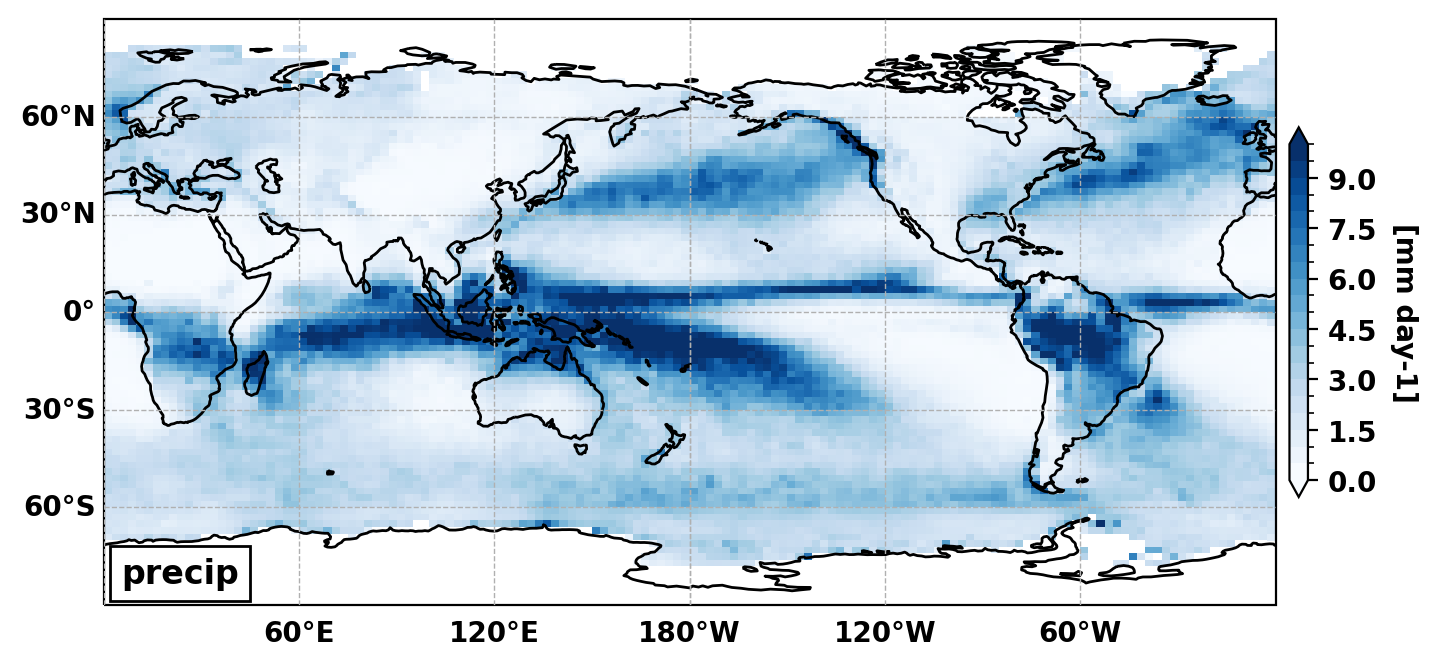

In [3]:
quick_map(prec,
          season='djf',
          field='prec',
          diff=False,
          cbar=True,
          mask=None, mask_color='w',
          boundaries=None,
          ax=None)

#### CUSTOM_MAP

Useful if you don't want to use the preset colormaps or vmin/vmax ranges from quick_map

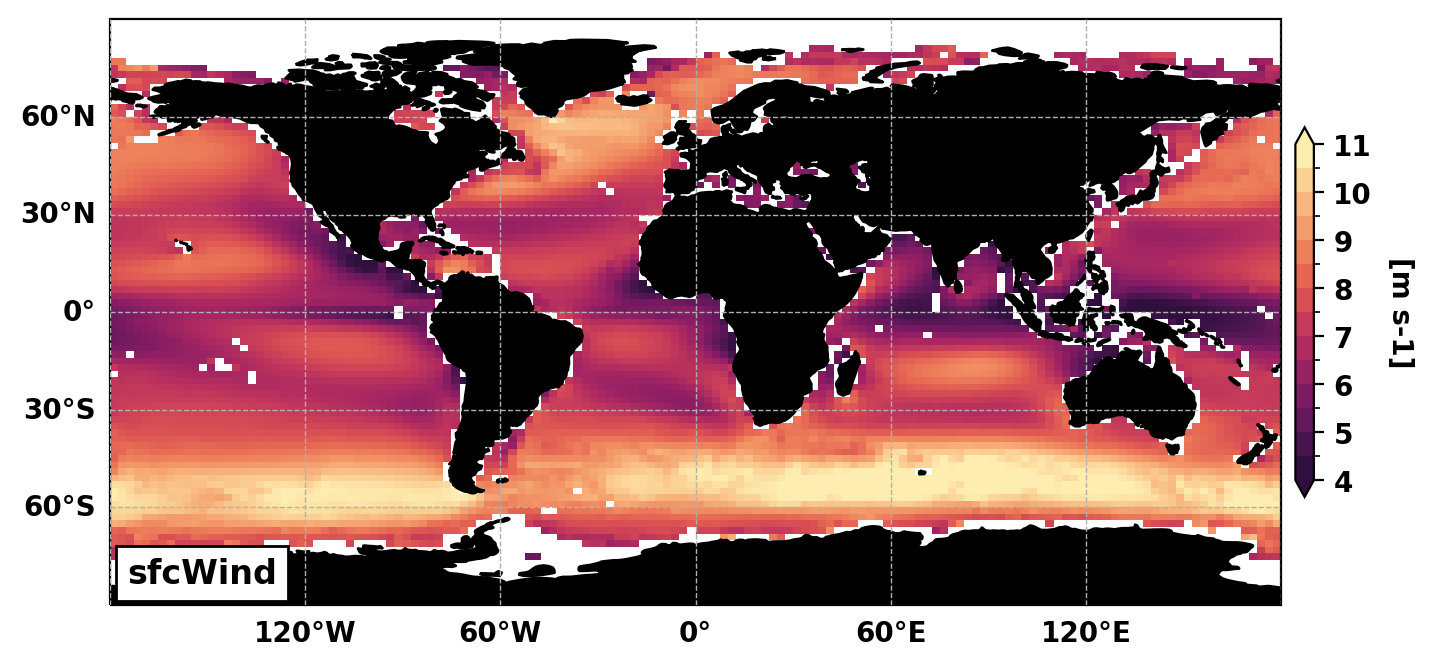

In [4]:
ccmap=cmocean.cm.matter_r
custom_map(obs.sfcWind,
           season='ann',
           vmin=4, vmax=11,
           cmap=ccmap, cbar=True,
           mask='land', mask_color='k',
           boundaries=None,
           ax=None)

#### USING CUSTOM FUNCTIONS TO MAKE A MULTI-PANEL MAP

Main difference is that you create the figure, designate the map projection, and create axes outside of the function. Then, plug in the subplot axes into the function.

It does look a little wonky if you set different map boundaries for each subplot.

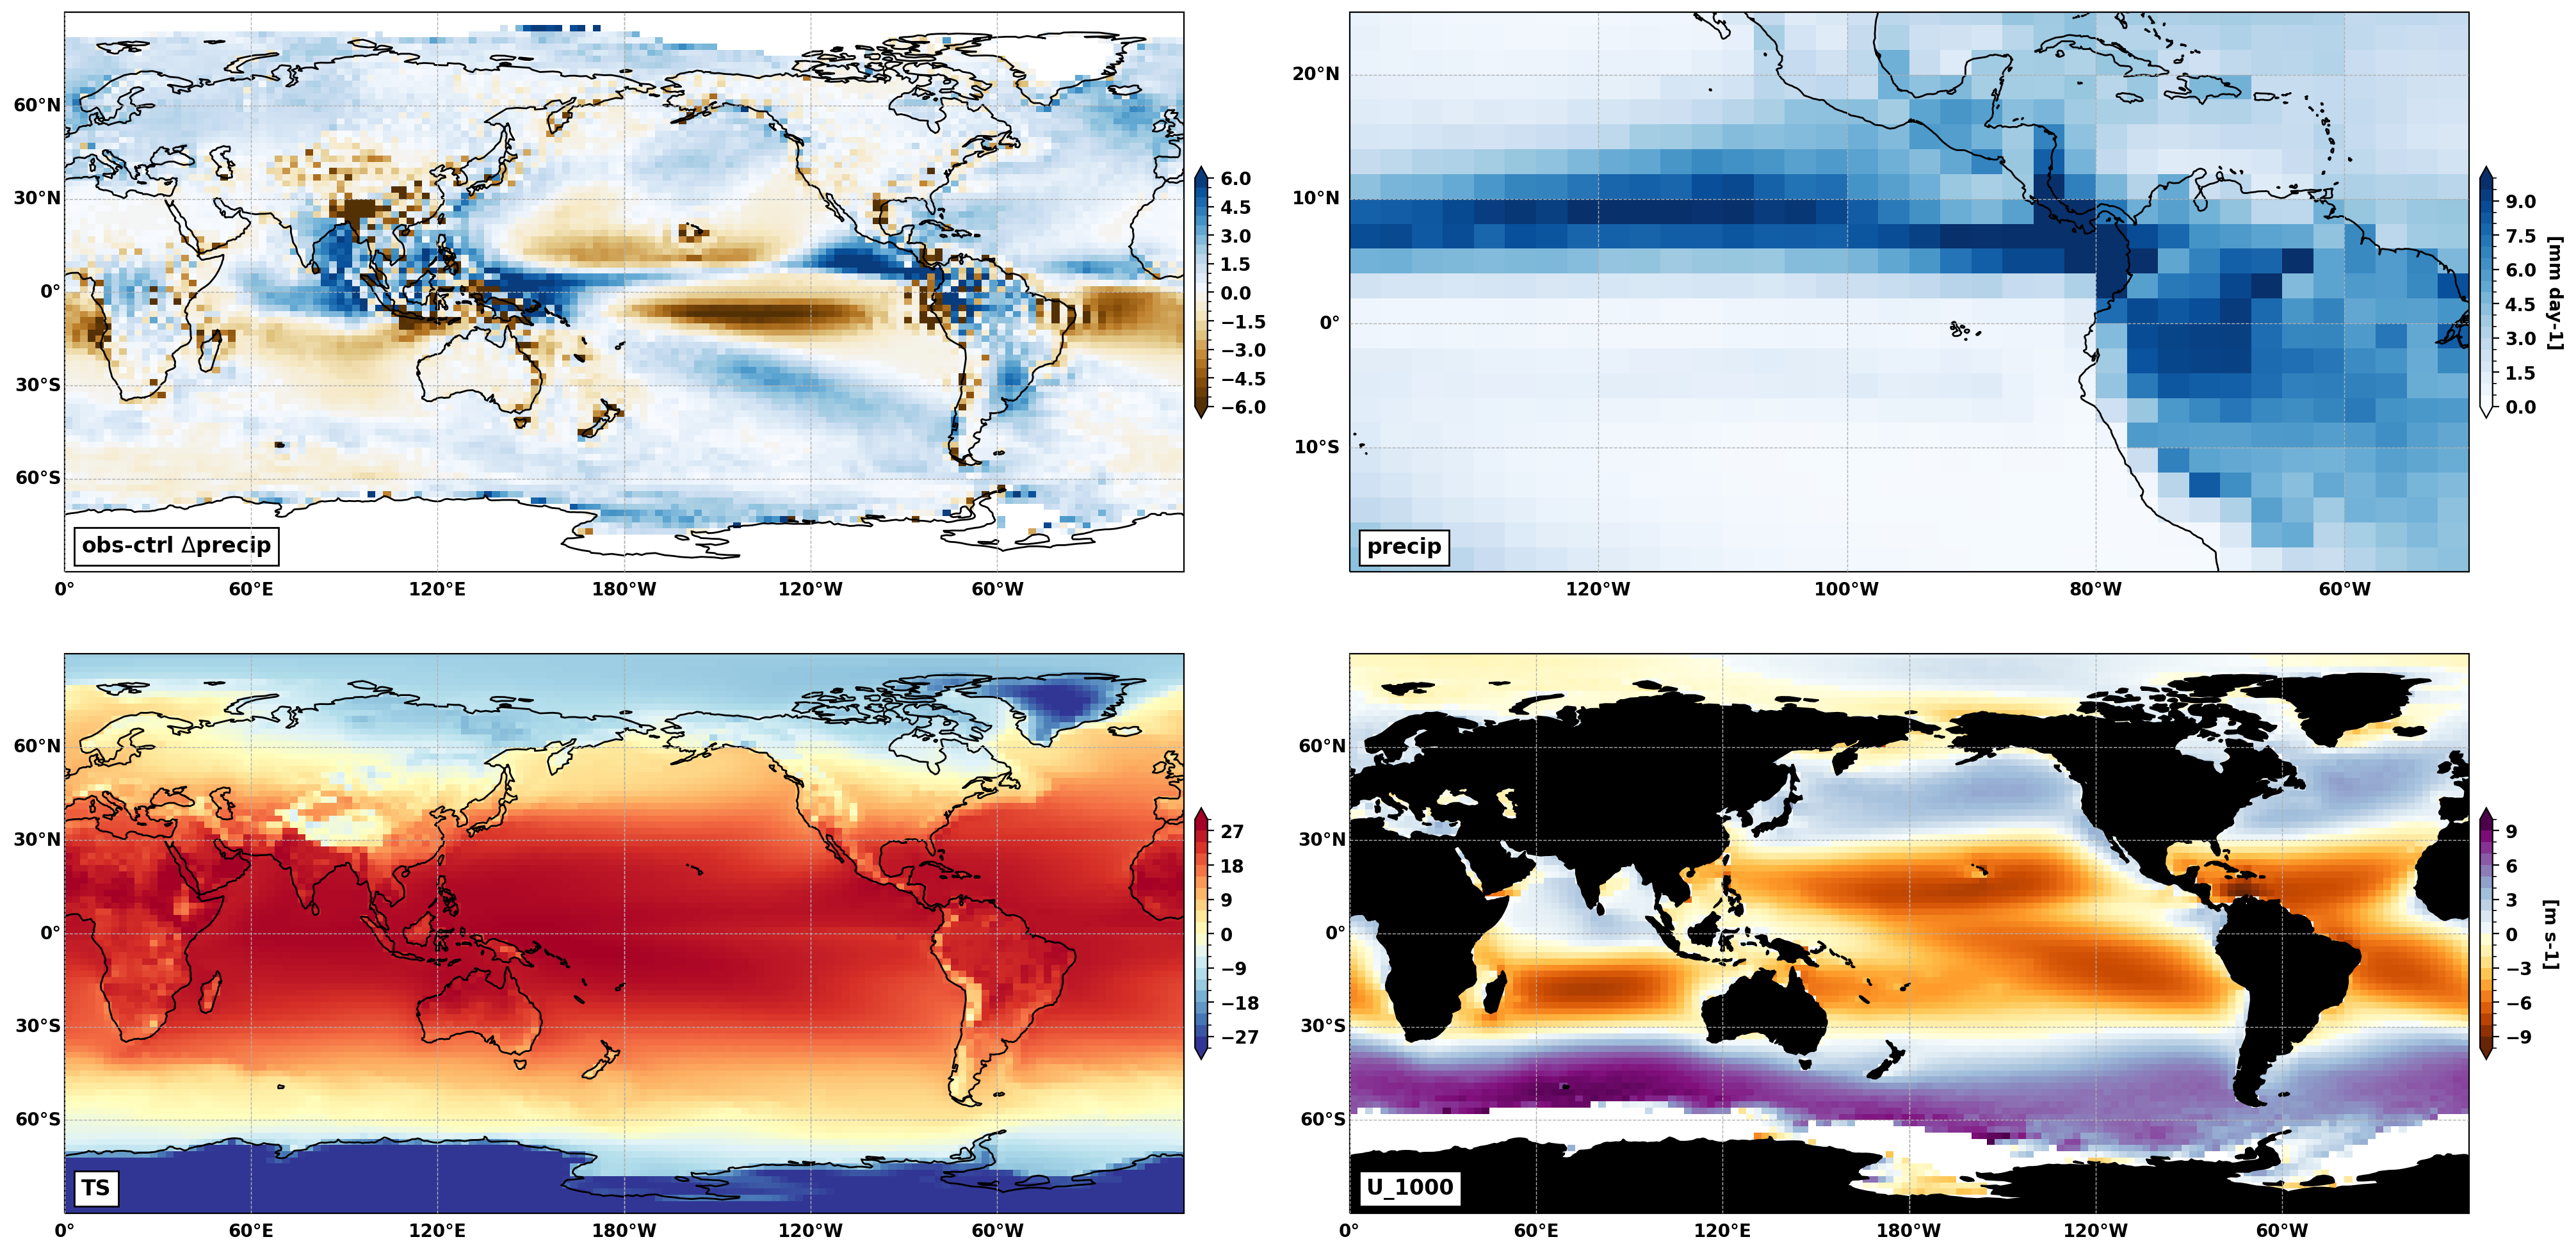

In [6]:
fig = plt.figure(figsize=(20, 10), layout='constrained')
proj=ccrs.PlateCarree(central_longitude=180)

ax = plt.subplot2grid((2, 2), (0, 0), colspan=1, rowspan=1, projection=proj)
quick_map((prec-prec_ctrl),
          season='ann',
          field='prec',
          diff=True,
          cbar=True,
          mask=None, mask_color='w',
          boundaries=None,
          label='obs-ctrl $\Delta$precip',
          ax=ax)

ax = plt.subplot2grid((2, 2), (0, 1), colspan=1, rowspan=1, projection=proj)
quick_map(prec,
          season='ann',
          field='prec',
          diff=False,
          cbar=True,
          mask=None, mask_color='w',
          boundaries=[-140,-50,-20,25],
          ax=ax)

ax = plt.subplot2grid((2, 2), (1, 0), colspan=1, rowspan=1, projection=proj)
quick_map(ts-273,
          season='ann',
          field='ts',
          diff=False,
          cbar=True,
          mask=None, mask_color='w',
          boundaries=None,
          ax=ax)

ax = plt.subplot2grid((2, 2), (1, 1), colspan=1, rowspan=1, projection=proj)
quick_map(obs.U_1000,
          season='ann',
          field='u',
          diff=False,
          cbar=True,
          mask='land', mask_color='k',
          boundaries=None,
          ax=ax)

#### PLOT_FIELD_DIFF

Use to compare fields from two simulations or obs and a simulation. A little clunky at the moment (i.e. requires a lot of inputs), might want to consider streamlining

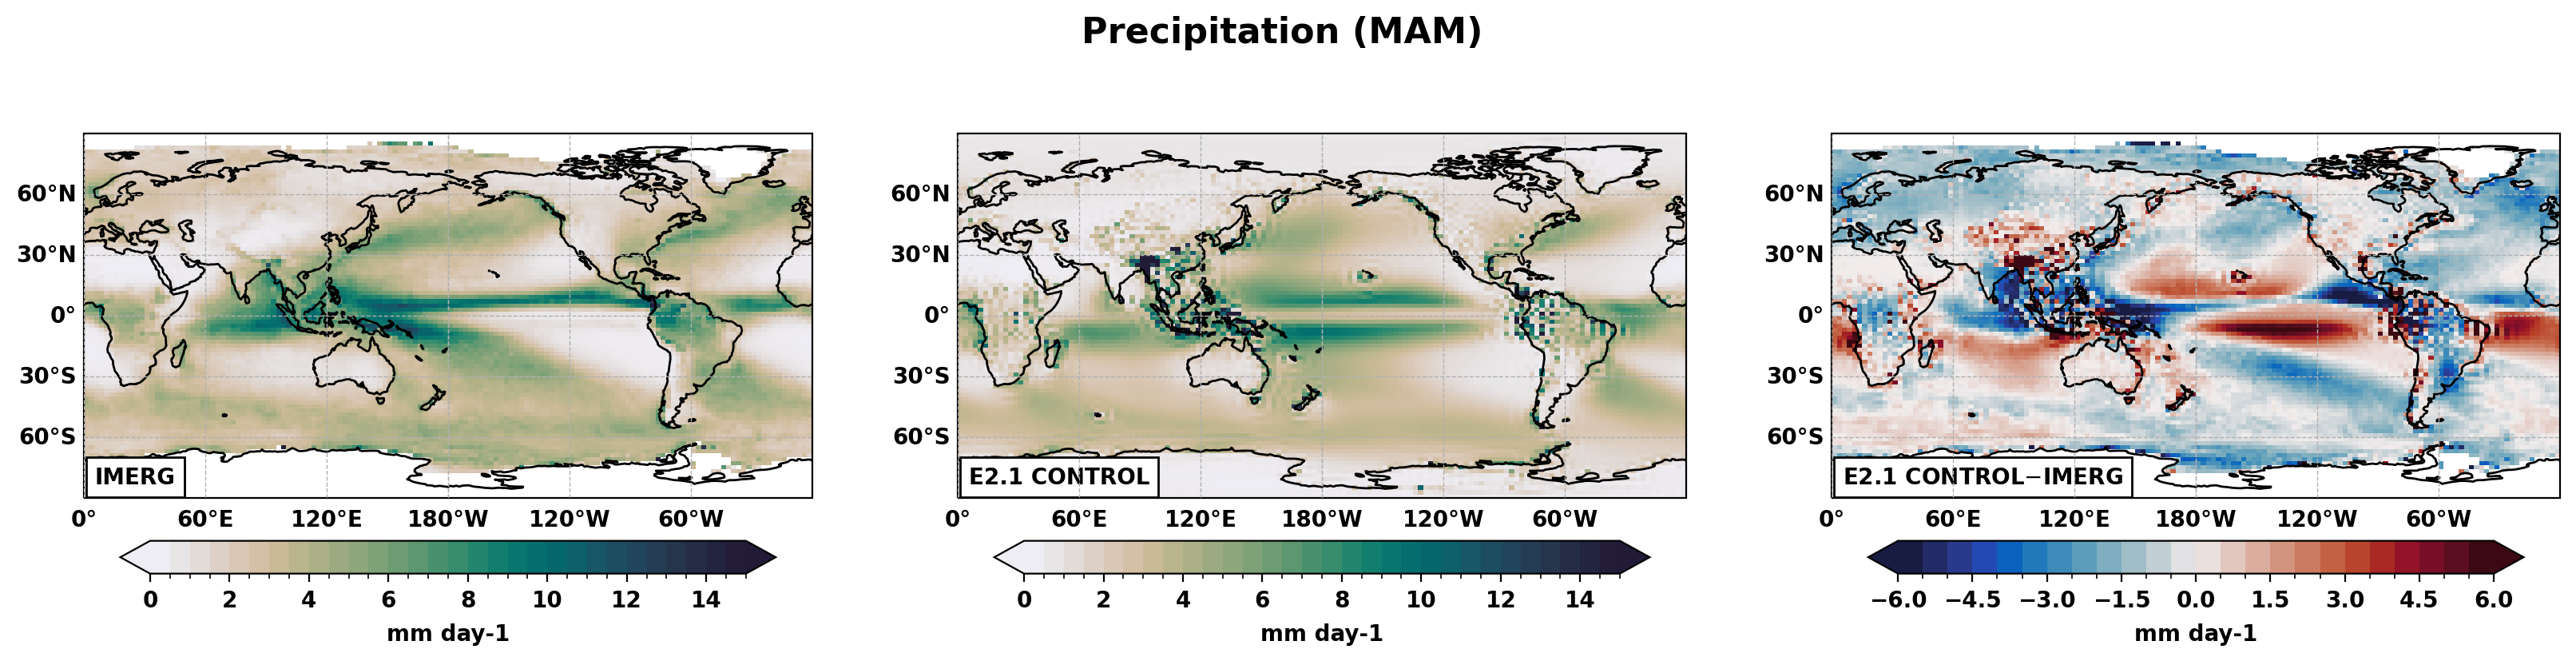

In [7]:
cmap_fld=cmocean.cm.rain
cmap_diff=cmocean.cm.balance
plot_field_diff(prec, prec_ctrl, season='MAM',
                vmin_fld=0, vmax_fld=15, cmap_fld=cmap_fld,
                vmin_diff=-6, vmax_diff=6, cmap_diff=cmap_diff,
                mask=None, boundaries=None, cl=180,
                var1_name='IMERG', var2_name='E2.1 CONTROL',
                save=False, ofile=None)

#### PLOT ZONAL MEAN (in development)

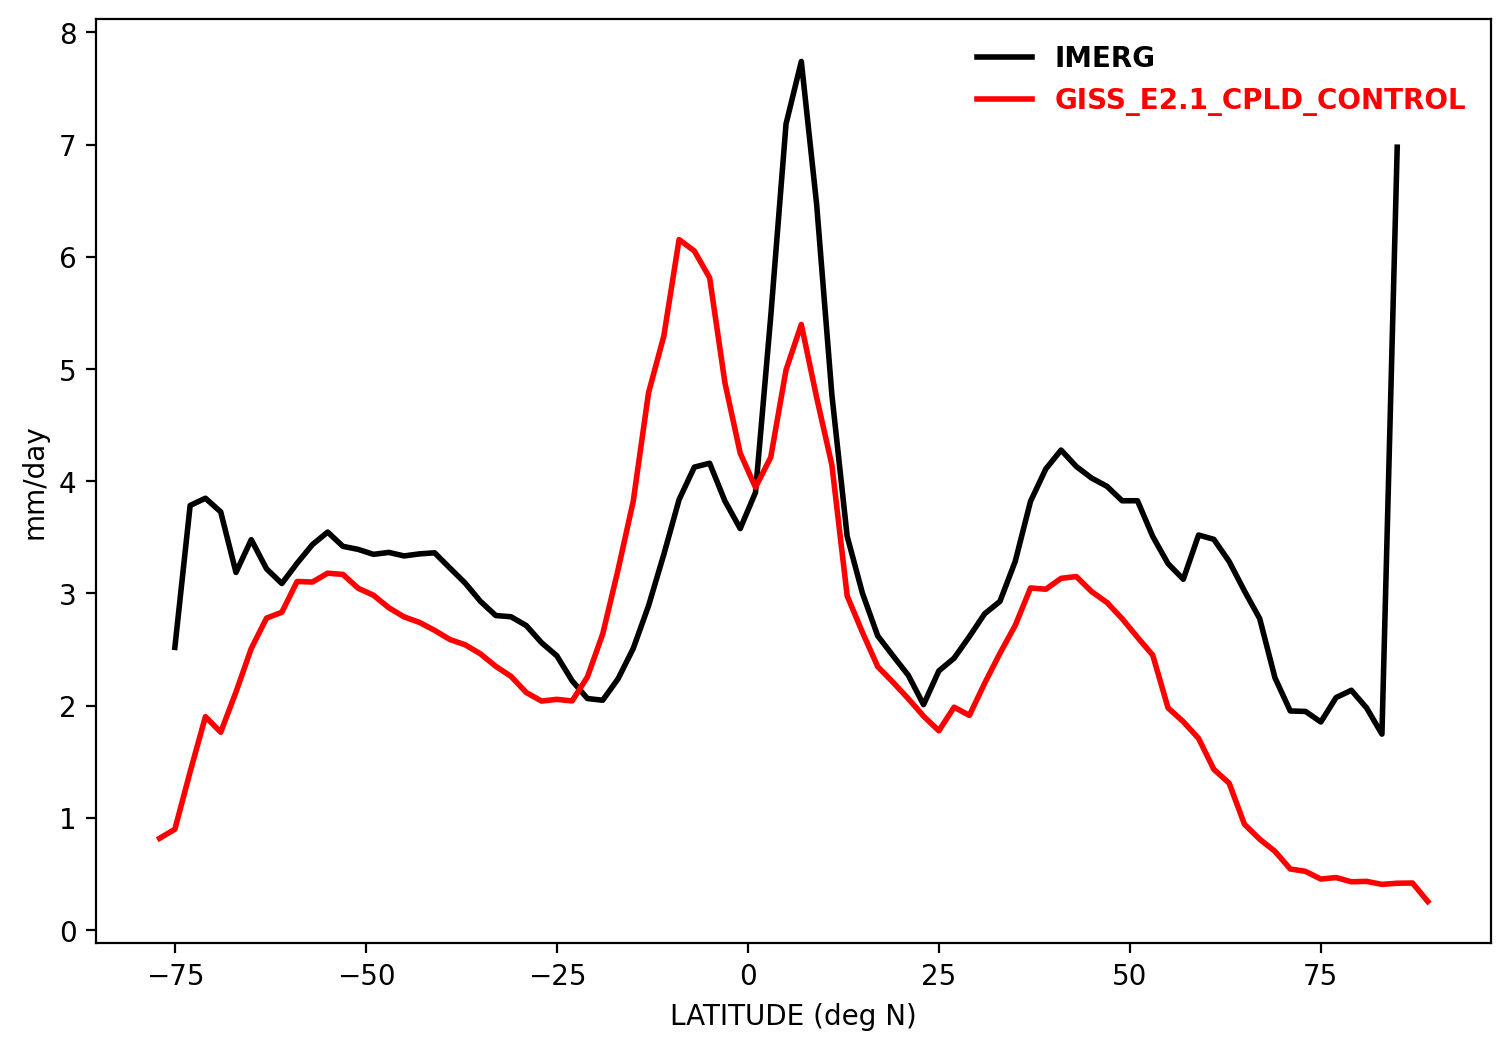

In [8]:
prec_obs=prec.interp_like(masks)
prec_obs=prec_obs.where(masks.focean==1,np.nan)

prec_ctl=prec_ctrl.interp_like(masks)
prec_ctl=prec_ctl.where(masks.focean==1,np.nan)

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(9,6))

plot_zonal_mean(prec_obs, season='mam', col='k', mask=None, bounds=None, ax=axs)
plot_zonal_mean(prec_ctl, season='mam', col='r', mask=None, bounds=None, ax=axs)

# test

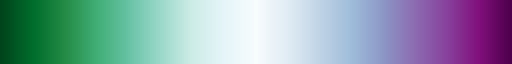

In [171]:
#GnBu_r #YlOrBr
ccmap = combine_cmaps(plt.colormaps['BuGn_r'], 
                      plt.colormaps['BuPu'],
                      range_low=[0,1], range_up=[0,1],
                      n_low=128, n_up=128)
ccmap

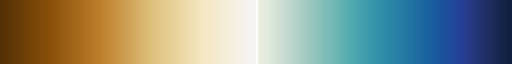

In [86]:
browns = cm.BrBG(np.linspace(0,0.5, num=129))
white = [(1,1,1,1)]*1
blues = cmocean.cm.delta_r(np.linspace(0.52,1.0, num=128))
colors = np.vstack((browns, white, blues))
ccmap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
ccmap